**Abdul Hanan**
**i170131**
**Data Mining Lab Task 9**

Download dataset from http://yann.lecun.com/exdb/mnist/

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [ ]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [ ]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

In [ ]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [ ]:
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

In [ ]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [ ]:
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: A)')

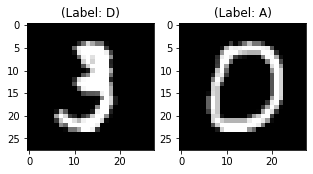

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [ ]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [ ]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [ ]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [ ]:
batch_size = 64
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

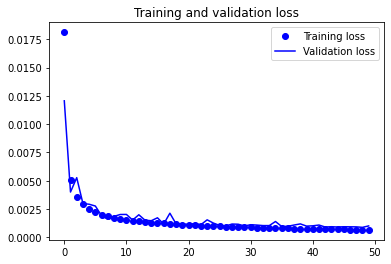

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder.save_weights('autoencoder.h5')

In [ ]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

**AUTO ENCODER FOR CLASSIFICATION**

In [ ]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [ ]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [ ]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [ ]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [ ]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [ ]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
full_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_37 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 14, 14, 64)        1849

In [ ]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=30,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 7s 146us/step - loss: 0.2179 - accuracy: 0.9358 - val_loss: 0.1283 - val_accuracy: 0.9628
Epoch 2/30
48000/48000 [==============================] - 7s 136us/step - loss: 0.0717 - accuracy: 0.9774 - val_loss: 0.1339 - val_accuracy: 0.9640
Epoch 3/30
48000/48000 [==============================] - 6s 135us/step - loss: 0.0492 - accuracy: 0.9840 - val_loss: 0.1483 - val_accuracy: 0.9667
Epoch 4/30
48000/48000 [==============================] - 6s 135us/step - loss: 0.0398 - accuracy: 0.9871 - val_loss: 0.1444 - val_accuracy: 0.9682
Epoch 5/30
48000/48000 [==============================] - 7s 137us/step - loss: 0.0309 - accuracy: 0.9900 - val_loss: 0.1451 - val_accuracy: 0.9695
Epoch 6/30
48000/48000 [==============================] - 6s 134us/step - loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.1772 - val_accuracy: 0.9708
Epoch 7/30
48000/48000 [==============================] - 7s 1

In [ ]:
full_model.save_weights('autoencoder_classification.h5')

In [ ]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [ ]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=30,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 19s 405us/step - loss: 0.0843 - accuracy: 0.9886 - val_loss: 0.2602 - val_accuracy: 0.9760
Epoch 2/30
48000/48000 [==============================] - 18s 377us/step - loss: 0.0442 - accuracy: 0.9933 - val_loss: 0.2634 - val_accuracy: 0.9779
Epoch 3/30
48000/48000 [==============================] - 18s 377us/step - loss: 0.0451 - accuracy: 0.9925 - val_loss: 0.2150 - val_accuracy: 0.9803
Epoch 4/30
48000/48000 [==============================] - 18s 375us/step - loss: 0.0262 - accuracy: 0.9951 - val_loss: 0.2163 - val_accuracy: 0.9789
Epoch 5/30
48000/48000 [==============================] - 18s 374us/step - loss: 0.0308 - accuracy: 0.9948 - val_loss: 0.2406 - val_accuracy: 0.9787
Epoch 6/30
48000/48000 [==============================] - 18s 374us/step - loss: 0.0267 - accuracy: 0.9952 - val_loss: 0.2052 - val_accuracy: 0.9794
Epoch 7/30
48000/48000 [==============================] 

In [ ]:
full_model.save_weights('classification_complete.h5')

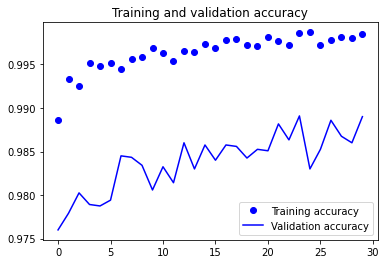

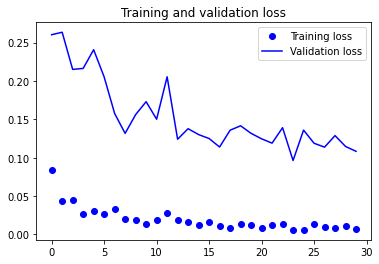

In [ ]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.10951367409736663
Test accuracy: 0.9890999794006348


In [ ]:
predicted_classes = full_model.predict(test_data)

Found %d correct labels 9891


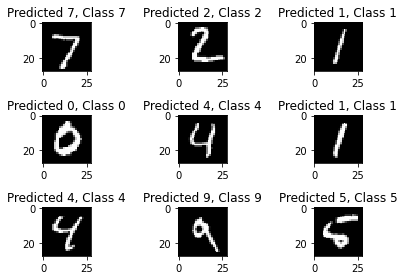

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct labels", len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found %d correct labels 109


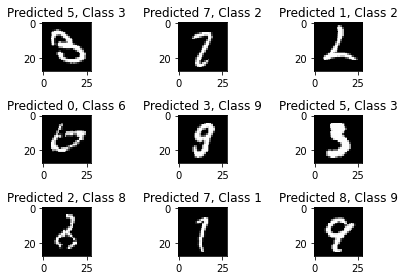

In [ ]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print("Found %d correct labels", len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()